### Import Library

In [2]:
from __future__ import division
import cv2 
import numpy as np
import glob
import csv
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Feature Extraction

Menggunakan Ekstraksi fitur HSV. Step yang digunakan adalah:
1. Masking Dataset
2. Gunakan Ekstraksi fitur HSV, lalu simpan ke dalam bentuk CSV

#### Masking

In [3]:
# Path folder utama yang berisi subfolder untuk setiap kelas
folder_utama = '../DATASET'

# Membaca semua subfolder di dalam folder utama
kelas_folders = glob.glob(os.path.join(folder_utama, '*'))

for kelas_folder in kelas_folders:
    # Membaca semua file gambar dalam subfolder kelas
    path = os.path.join(kelas_folder, '*.*')
    
    for bb, file in enumerate(glob.glob(path)):
        # Membuat kernel untuk nanti masking
        kernelOpen = np.ones((5, 5))
        kernelClose = np.ones((20, 20))

        # Baca gambar rgb
        rgb = cv2.imread(file)

        # Konversi BGR ke HSV
        hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)

        # Menambahkan range untuk warna putih
        lower_white = np.array([0, 0, 168])
        upper_white = np.array([172, 111, 255])

        # Membuat mask dari warna putih
        whitemask = cv2.inRange(hsv, lower_white, upper_white)

        # Inverse mask putih agar yang terdeteksi adalah yang bukan putih
        non_whitemask = cv2.bitwise_not(whitemask)

        # Menambahkan range untuk warna abu-abu
        lower_grey = np.array([0, 0, 100])
        upper_grey = np.array([172, 30, 255])

        # Membuat mask dari warna abu-abu
        greymask = cv2.inRange(hsv, lower_grey, upper_grey)

        # Menggabungkan 2 mask untuk mendeteksi warna putih dan abu-abu
        non_whitemask_no_grey = cv2.bitwise_and(non_whitemask, cv2.bitwise_not(greymask))

        # Gunakan operasi open dengan kernel yang di atas
        maskOpen = cv2.morphologyEx(non_whitemask_no_grey, cv2.MORPH_OPEN, kernelOpen)

        # Hasil dari open dipakai di close ini
        maskClose = cv2.morphologyEx(maskOpen, cv2.MORPH_CLOSE, kernelClose)

        # Hasil akhirnya masking dari close
        maskFinal = maskClose

        # Setelah itu gunakan bitwise untuk menyatukan gambarnya, hanya menggunakan hsv
        maskFinally = cv2.bitwise_and(hsv, hsv, mask = maskFinal)

        # Crop citra dengan ukuran yang diberikan
        lr = 500
        ub = 1000
        cropped_img = maskFinally[ub:-ub, lr:-lr]

        # Simpan gambar hasil masking dan resizing sesuai dengan struktur folder
        output_folder = os.path.join('masking_folder', os.path.basename(kelas_folder))
        os.makedirs(output_folder, exist_ok=True)
        
        # Gunakan label kelas sebagai nama file
        class_label = os.path.basename(kelas_folder)
        output_filename = f'masking_{class_label}_{bb}.jpg'
        print("===================================================")
        output_path = os.path.join(output_folder, output_filename)
        
        try:
            cv2.imwrite(output_path, cropped_img)
            print(f"Saved: {output_filename}")
        except Exception as e:
            print(f"Error saving {output_filename}: {e}")

Saved: masking_BUSUK_0.jpg
Saved: masking_BUSUK_1.jpg
Saved: masking_BUSUK_2.jpg
Saved: masking_BUSUK_3.jpg
Saved: masking_BUSUK_4.jpg
Saved: masking_BUSUK_5.jpg
Saved: masking_BUSUK_6.jpg
Saved: masking_BUSUK_7.jpg
Saved: masking_BUSUK_8.jpg
Saved: masking_BUSUK_9.jpg
Saved: masking_BUSUK_10.jpg
Saved: masking_BUSUK_11.jpg
Saved: masking_BUSUK_12.jpg
Saved: masking_BUSUK_13.jpg
Saved: masking_BUSUK_14.jpg
Saved: masking_BUSUK_15.jpg
Saved: masking_BUSUK_16.jpg
Saved: masking_BUSUK_17.jpg
Saved: masking_BUSUK_18.jpg
Saved: masking_BUSUK_19.jpg
Saved: masking_BUSUK_20.jpg
Saved: masking_BUSUK_21.jpg
Saved: masking_BUSUK_22.jpg
Saved: masking_BUSUK_23.jpg
Saved: masking_BUSUK_24.jpg
Saved: masking_BUSUK_25.jpg
Saved: masking_BUSUK_26.jpg
Saved: masking_BUSUK_27.jpg
Saved: masking_BUSUK_28.jpg
Saved: masking_BUSUK_29.jpg
Saved: masking_BUSUK_30.jpg
Saved: masking_BUSUK_31.jpg
Saved: masking_BUSUK_32.jpg
Saved: masking_BUSUK_33.jpg
Saved: masking_BUSUK_34.jpg
Saved: masking_BUSUK_35.jpg
Sa

#### Feature Extraction

In [4]:
# Fungsi untuk mengekstraksi fitur
def extract_hsv_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_hsv = np.mean(hsv, axis = (0, 1))
    return mean_hsv

# Path folder utama yang berisi subfolder untuk setiap kelas
folder_utama = 'masking_folder'

# nama file CSV yang akan di generate untuk menyimpan fitur
csv_filename = 'hsv_final_features.csv'

# Membuka file CSV saat akan ditulis
with open(csv_filename, 'w', newline = '') as csv_file:
    # Membuat objek writer CSV
    csv_writer = csv.writer(csv_file)
    
    # Membuat header row
    csv_writer.writerow(['Class', 'Mean_Hue', 'Mean_Saturation', 'Mean_Value'])

    # Membaca semua subfolder di dalam folder utama
    kelas_folders = glob.glob(os.path.join(folder_utama, '*'))

    for kelas_folder in kelas_folders:
        # Membaca semua file gambar dalam subfolder kelas
        path = os.path.join(kelas_folder, '*.*')
        
        for bb, file in enumerate(glob.glob(path)):
            # Baca gambar hsv
            hsv = cv2.imread(file)

            # Ekstraksi fitur HSV
            hsv_features = extract_hsv_features(hsv)

            # Menambahkan fitur ke dalam CSV
            class_label = os.path.basename(kelas_folder)
            csv_writer.writerow([class_label] + list(hsv_features))

print(f"HSV features extracted and saved to {csv_filename}")

HSV features extracted and saved to hsv_final_features.csv


In [5]:
import cv2
import matplotlib.pyplot as plt

# Membaca gambar
input_image = cv2.imread('../DATASET/MATANG/IMG_20231216_180326.jpg')
masked_image = cv2.imread('hsv_folder\MATANG\Image HSV_MATANG_146.jpg')

# Periksa apakah gambar berhasil dibaca
if input_image is None:
    print("Error: Gambar asli tidak dapat dibaca. Periksa jalur file.")
else:
    print("Gambar asli berhasil dibaca.")

if masked_image is None:
    print("Error: Gambar setelah masking tidak dapat dibaca. Periksa jalur file.")
else:
    print("Gambar setelah masking berhasil dibaca.")

# Jika kedua gambar berhasil dibaca, lanjutkan ke konversi dan plotting
if input_image is not None and masked_image is not None:
    # Konversi gambar ke monochrome
    input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    masked_image_gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # Plotting gambar asli dan setelah masking dalam bentuk monochrome
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Gambar Asli Monochrome")
    plt.imshow(input_image_gray, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Setelah Masking Monochrome")
    plt.imshow(masked_image_gray, cmap='gray')
    plt.axis("off")

    plt.show()


Gambar asli berhasil dibaca.
Error: Gambar setelah masking tidak dapat dibaca. Periksa jalur file.


### Model Prediction

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mengambil data fitur CSV ke dalam DataFrame
csv_filename = 'hsv_final_features.csv'
df = pd.read_csv(csv_filename)

# Pisahkan label dan fitur
X = df[['Mean_Hue', 'Mean_Saturation', 'Mean_Value']]
y = df['Class']

# Memisahkan data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Menggunakan StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Membuat objek k-NN classifier
knn_classifier = KNeighborsClassifier(metric='minkowski', n_neighbors = 3, weights = 'distance')  

# Melatih k-NN classifier
knn_classifier.fit(X_train, y_train)

y_hat = knn_classifier.predict(X_train)

training_set = accuracy_score(y_train, y_hat)
print(f'Training set accuracy: {training_set * 100:.2f}%') 

# Menghitung nilai precision, recall, dan F1 score
precision = precision_score(y_train, y_hat, average = 'weighted')
recall = recall_score(y_train, y_hat, average = 'weighted')
f1 = f1_score(y_train, y_hat, average = 'weighted')

# Menampilkan nilai precision, recall, dan F1 score
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Training set accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Mengambil data fitur CSV ke dalam DataFrame
csv_filename = 'hsv_final_features.csv'
df = pd.read_csv(csv_filename)

# Pisahkan label dan fitur
X = df[['Mean_Hue', 'Mean_Saturation', 'Mean_Value']]
y = df['Class']

# Memisahkan data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menggunakan StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Membuat objek k-NN classifier
knn_classifier = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

# Melatih k-NN classifier
knn_classifier.fit(X_train, y_train)

# Prediksi pada data training
y_train_pred = knn_classifier.predict(X_train)

# Prediksi pada data testing
y_test_pred = knn_classifier.predict(X_test)

# Menampilkan classification report untuk data training
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))

# Menampilkan classification report untuk data testing
print("Testing Set Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Set Classification Report:
               precision    recall  f1-score   support

        BUSUK       1.00      1.00      1.00       134
       MATANG       1.00      1.00      1.00       132
       MENTAH       1.00      1.00      1.00       135
 MENUJU BUSUK       1.00      1.00      1.00       138
MENUJU MATANG       1.00      1.00      1.00       133

     accuracy                           1.00       672
    macro avg       1.00      1.00      1.00       672
 weighted avg       1.00      1.00      1.00       672

Testing Set Classification Report:
               precision    recall  f1-score   support

        BUSUK       0.94      0.94      0.94        33
       MATANG       0.97      0.94      0.96        36
       MENTAH       1.00      1.00      1.00        34
 MENUJU BUSUK       0.88      0.91      0.89        32
MENUJU MATANG       1.00      1.00      1.00        33

     accuracy                           0.96       168
    macro avg       0.96      0.96      0.96

#### Evaluation

Confusion Matrix:
[[31  0  0  2  0]
 [ 0 34  0  2  0]
 [ 0  0 34  0  0]
 [ 2  1  0 29  0]
 [ 0  0  0  0 33]]


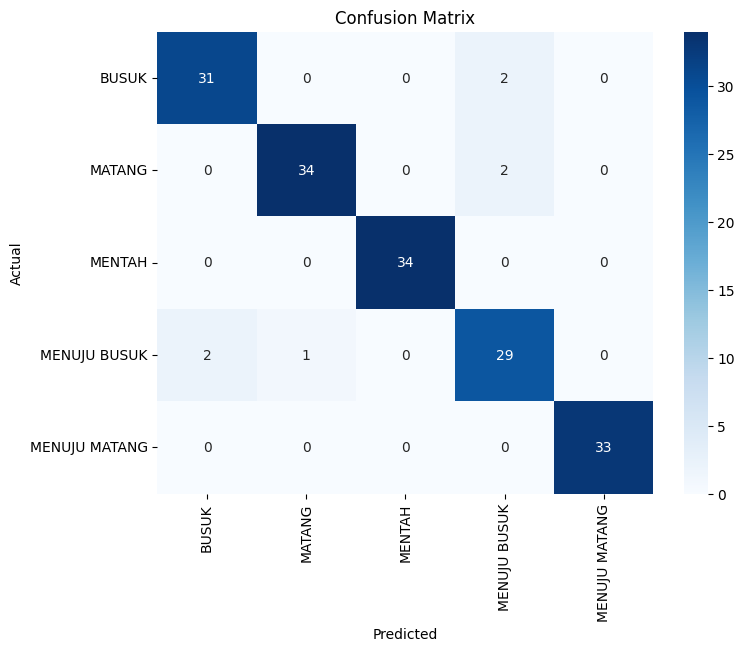

Accuracy: 95.83%
Precision: 95.89%
Recall: 95.83%
F1 Score: 95.85%


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi dalam test set
y_pred = knn_classifier.predict(X_test)

# Menampilkan confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Melakukan visualisasi confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = knn_classifier.classes_, yticklabels = knn_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Menghitung accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Menghitung precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

In [9]:
model_filename = 'knn_model.pkl'
joblib.dump(knn_classifier, model_filename)

print(f"K-NN model saved to {model_filename}")

K-NN model saved to knn_model.pkl


#### Hyper-Parameter Tuning

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Membaca data fitur CSV ke dalam DataFrame
csv_filename = 'hsv_final_features.csv'
df = pd.read_csv(csv_filename)

# Memisahkan label dan fitur
X = df[['Mean_Hue', 'Mean_Saturation', 'Mean_Value']]
y = df['Class']

# Memisahkan dataset menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Membuat objek k-NN classifier
knn_classifier = KNeighborsClassifier()

# Mendefinisikan parameter yang ingin dicoba untuk k-NN
param_grid = {
    'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'weights' : ['uniform', 'distance'],
    'metric' : ['minkowski', 'euclidean', 'manhattan']
    }

# Memanggil fungsi GridSearchCV dengan parameter cross-validation yang ditentukan 
grid_search = GridSearchCV(knn_classifier, param_grid, cv = 7, verbose = 1, n_jobs =- 1)
grid_search.fit(X_train, y_train)

# Melatih k-NN classifier dengan parameter terbaik
best_knn_classifier = grid_search.best_estimator_
best_knn_classifier.fit(X_train, y_train)

# Melakukan prediksi dalam test set
y_pred = best_knn_classifier.predict(X_test)

Fitting 7 folds for each of 54 candidates, totalling 378 fits


In [11]:
y_hat = best_knn_classifier.predict(X_train)
y_knn = best_knn_classifier.predict(X_test)
training_set = accuracy_score(y_train, y_hat)
test_set = accuracy_score(y_test, y_knn)

print(f'Training set accuracy: {training_set * 100:.2f}%') 
print(f'Test set accuracy: {test_set * 100:.2f}%')

# Menghitung nilai precision, recall, dan F1 score
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')

# Menampilkan nilai precision, recall, dan F1 score
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Training set accuracy: 100.00%
Test set accuracy: 95.83%
Precision: 95.85%
Recall: 95.83%
F1 Score: 95.83%


### Save Model

In [12]:
# Menyimpan model k-NN terbaik ke dalam file pkl
best_model_filename = 'best_knn_model.pkl'
best_knn_model = grid_search.best_estimator_
joblib.dump(best_knn_model, best_model_filename)
print(f"K-NN best model saved to {best_model_filename}")

K-NN best model saved to best_knn_model.pkl
